# Gerekli Kütüphanelerin Kurulumu

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Veri Hakkında Temel Bilgiler

In [59]:
# Veri setini yükle
df = pd.read_csv('insurance.csv')
n = "\n"
print("Kolonları Görüntüle",
      df.columns,
      n,
      "Boyut Bilgisi",
      df.shape,
      n,
      "Veri Tipleri",
      df.dtypes,
      n,
      "İlk 10 Satır",
      df.head(10),
      n,
      "Son 4 Satır",
      df.tail(4),
      n,
      "Null Veri Sayısı",
      df.isnull().sum().sum(),
      n,
      "Genel İstatistikler",
      df.describe(),
      "Kategorik Değişkenlerin Kontrolü",
      df["children"].value_counts(),
      n,
      df["smoker"].value_counts(),
      n,
      df["region"].value_counts(),
      sep="\n"
      )

Kolonları Görüntüle
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


Boyut Bilgisi
(1338, 7)


Veri Tipleri
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


İlk 10 Satır
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  n



1.   Kategorik değişkenlerin tipleri int64!



# Label Encoder

In [63]:
# Kategorik sütunları içeren bir liste
categorical_columns = ['sex', 'children', 'smoker', 'region']

# For döngüsü ile kategorik sütunlara erişim
for column in categorical_columns:
    unique_values = df[column].unique()
    num_unique = len(unique_values)

    print(f"Sütun: {column}")
    print(f"Benzer Değerler: {unique_values}")
    print(f"Benzer Değer Sayısı: {num_unique}")
    print("=" * 30)

Sütun: sex
Benzer Değerler: ['female' 'male']
Benzer Değer Sayısı: 2
Sütun: children
Benzer Değerler: [0 1 3 2 5 4]
Benzer Değer Sayısı: 6
Sütun: smoker
Benzer Değerler: ['yes' 'no']
Benzer Değer Sayısı: 2
Sütun: region
Benzer Değerler: ['southwest' 'southeast' 'northwest' 'northeast']
Benzer Değer Sayısı: 4


# Outlier Değerlerin Kaldırılması

In [61]:
# Outlier Kolonları Belirle
outlier_columns = ['age', 'bmi',  'charges']

# Outlier kriteri ve IQR faktörünü belirle
outlier_factor = 1.5

for col in outlier_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_factor * IQR
    upper_bound = Q3 + outlier_factor * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Görselleştirme

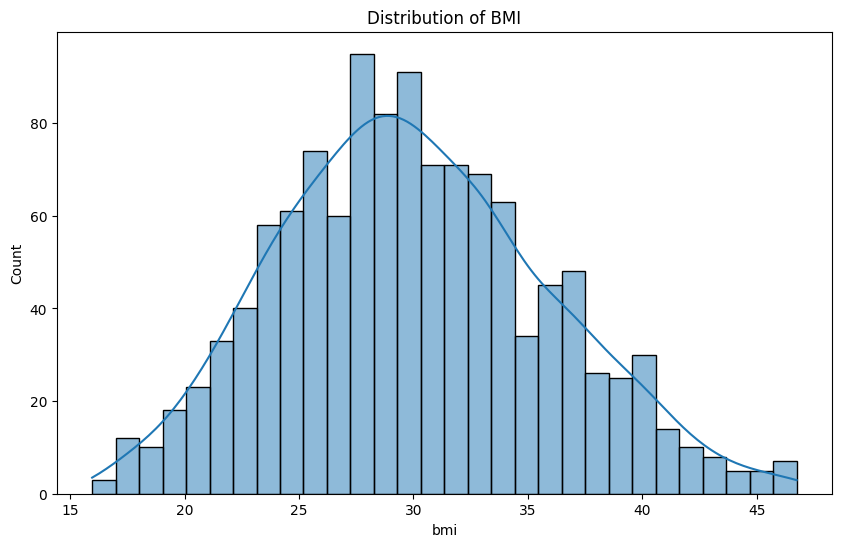

In [62]:
# Bmi Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title('Distribution of BMI')
plt.show()
# Diğer analizler aynı şekilde devam eder...


In [6]:
# Kategorik değişkenleri sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])
df['region'] = label_encoder.fit_transform(df['region'])

# One-Hot Encoding
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Verileri X ve y olarak ayırma
X = df.drop('charges', axis=1)
y = df['charges']

# Verileri eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verileri ölçeklendirme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# Farklı regresyon modellerini seçme
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR()
}

# Modelleri eğitme ve çapraz doğrulama ile performansı değerlendirme
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    results[model_name] = rmse_scores.mean()

# Modelleri performansa göre sıralama
sorted_results = sorted(results.items(), key=lambda x: x[1])
for model_name, rmse_score in sorted_results:
    print(f'{model_name}: RMSE = {rmse_score:.2f}')


Random Forest Regressor: RMSE = 4995.53
Linear Regression: RMSE = 6147.09
Support Vector Regressor: RMSE = 12566.80


In [8]:
# En iyi sonuç veren modeli seçme
best_model_name = sorted_results[0][0]
best_model = models[best_model_name]

# Grid Search ile hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve sonuçları yazdırma
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END ma

In [9]:
# En iyi modeli seçme
best_model = grid_search.best_estimator_

# Test verileri üzerinde tahmin yapma
y_pred = best_model.predict(X_test)

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Squared Error (MSE): 18722547.89
Mean Absolute Error (MAE): 2447.97
Root Mean Squared Error (RMSE): 4326.96


In [10]:
# Model seçimi ve eğitimi
best_model = RandomForestRegressor()  # Örnek olarak Random Forest Regressor seçildi
best_model.fit(X_train, y_train)



RandomForestRegressor()

In [11]:
# Grid Search ile hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi model ve sonuçları
best_model = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", best_rmse)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END ma